# Graphs for paper for combinations

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [8]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [9]:
import sys
sys.path.append('../')

In [10]:
import neptune

In [18]:
## download from neptune
LOC_START_ID, LOC_END_ID = 771, 1002
LOC_SKIP_IDS = []
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]

In [20]:
len(LOC_RUNS)

197

In [24]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")

In [169]:
def fetch_metadata(run_id: str) -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (False, True, _, "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBSCAN-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBSCAN-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}"

        metric = run["scores"]["metric"].fetch()
        ac2 = metric["AC_2"]
        ac5 = metric["AC_5"]
        avg5 = metric["AVG_5"]
        elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
        return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction, "localization_method": localization,
                    "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}

In [170]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run) for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-773
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-774
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-797
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-784
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-791
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-771
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-779
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-777
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-801
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-794
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-780
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-792
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-803
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-783
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-781
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-782
https://app.neptune.ai/y

In [171]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    display(loc_tsdr_df.set_index(["dataset", "reduction_method", "localization_method"]).sort_index())

ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.312500  0.462500  0.360000   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.300000  0.537500  0.365000   
                           e-Diagnosis          0.012500  0.012500  0.012500   
          HDBSCAN-R        CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.362500  0.512500  0.412500   
                           e-Diagnosis          0.000000  0.012500  0.002500   
          HDBSCAN-SBD      CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.375000  0.587500  0.427500   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          K-S test         CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.312500  0.487500  0.367500   
                           e-Diagnosis          0.012500  0.012500  0.012500   
          NSigma           CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.287500  0.537500  0.380000   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          None             CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.275000  0.500000  0.357500   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          TSifter          CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.287500  0.437500  0.340000   
                           e-Diagnosis          0.062500  0.137500  0.092500   
SS-medium BIRCH            CG+PageRank          0.037500  0.037500  0.035000   
                           RCD                  0.800000  0.900000  0.810000   
                           e-Diagnosis          0.025000  0.025000  0.020000   
          FluxInfer-AD     CG+PageRank          0.062500  0.075000  0.065000   
                           RCD                  0.737500  0.887500  0.777500   
                           e-Diagnosis          0.025000  0.075000  0.035000   
          HDBSCAN-R        CG+PageRank          0.050000  0.150000  0.080000   
                           RCD                  0.775000  0.862500  0.770000   
                           e-Diagnosis          0.075000  0.362500  0.175000   
          HDBSCAN-SBD      CG+PageRank          0.075000  0.175000  0.102500   
                           RCD                  0.825000  0.900000  0.827500   
                           e-Diagnosis          0.050000  0.262500  0.127500   
          K-S test         CG+PageRank          0.050000  0.075000  0.057500   
                           RCD                  0.737500  0.900000  0.797500   
                           e-Diagnosis          0.025000  0.075000  0.035000   
          NSigma           CG+PageRank          0.075000  0.087500  0.077500   
                           RCD                  0.787500  0.912500  0.810000   
                           e-Diagnosis          0.037500  0.050000  0.037500   
          None             CG+PageRank          0.075000  0.100000  0.087500   
                           LiNGAM+HT            0.333333  0.444444  0.355556   
                           RCD                  0.725000  0.887500  0.765000   
                           e-Diagnosis          0.025000  0.037500  0.022500   
          TSifter          CG+PageRank          0.050000  0.087500  0.065000   
                           RCD                  0.825000  0.925000  0.840000   
                           e-Diagnosis          0.27

## Load tsdr

In [46]:
TSDR_START_ID, TSDR_END_ID = 583, 630
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]

In [130]:
def fetch_metadata_of_tsdr(run_id: str) -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (False, True, _, "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBSCAN-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBSCAN-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}"

        scores = run["scores"].fetch()
        frr = scores["reduction_rate_mean"]
        rfr = scores["cause_metrics"]["recall_mandatory_mean"]
        rfp = scores["cause_metrics"]["proportion_mandatory_mean"]
        num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
        num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
        elapsed_time = scores["elapsed_time_min"]
        rs_scores = scores["random_selection_perf"]
        return {
            "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
            "reduction_method": reduction,
            "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
            "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
            "rs_ac@2": rs_scores["AC_2"], "rs_ac@5": rs_scores["AC_5"], "rs_avg@5": rs_scores["AVG_5"],
        }

In [131]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run) for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-588
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-596
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-604
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-584
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-613
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-594
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-599
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-583
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-587
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-588/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-598
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-585
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-590
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-602
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-586
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-610
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-605
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-597
Shutting down background jobs, please wait a moment...
Done!
Explore the metada

In [150]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBSCAN-SBD", "HDBSCAN-R", "TSifter"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]
datasets = ss_datasets + tt_datasets
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, reduction_methods], names=['dataset', 'Reduction Method'])
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''])
tsdr_df = pd.DataFrame(tsdr_items).set_index(['dataset', 'reduction_method']).reindex(
    index=multi_level_indexes)

#### Sock shop only

In [149]:

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [ss_datasets, reduction_methods], names=['dataset', 'Reduction Method'])
    multi_level_cols = pd.MultiIndex.from_product(
        [ss_datasets, metrics], names=['', ''])
    ss_tsdr_df = pd.DataFrame(tsdr_items).set_index(['dataset', 'reduction_method']).reindex(
        index=multi_level_indexes)
    df_pivot = ss_tsdr_df.unstack('dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=reduction_methods, columns=multi_level_cols,
    )
    display(df_pivot)

SS-small                                SS-medium            \
                       FRR     RFR       RFP elapsed_time       FRR       RFR   
Reduction Method                                                                
None              0.000000  1.0000  0.015524       0.2724  0.000000  1.000000   
NSigma            0.130180  0.9875  0.017736       0.4942  0.176448  0.987500   
BIRCH             0.159377  1.0000  0.018771       0.3243  0.184032  1.000000   
K-S test          0.132119  1.0000  0.018183       0.5167  0.136322  1.000000   
FluxInfer-AD      0.132119  1.0000  0.018183       0.5217  0.136322  1.000000   
HDBSCAN-SBD       0.458345  0.4125  0.011807       0.5631  0.689745  0.255417   
HDBSCAN-R         0.458954  0.4000  0.011471       0.5882  0.694773  0.240833   
TSifter           0.357078  0.9250  0.024158       0.6929  0.470810  0.929167   

                                         SS-large                      \
                       RFP elapsed_time       FRR       RFR       RFP   
Reduction Method                                                        
None              0.023750       0.2878  0.000000  1.000000  0.004998   
NSigma            0.028246       0.5426  0.318397  0.962538  0.006948   
BIRCH             0.029083       0.3654  0.240782  0.976174  0.006346   
K-S test          0.027484       0.5648  0.119697  0.996875  0.005642   
FluxInfer-AD      0.027484       0.5615  0.119697  0.996875  0.005642   
HDBSCAN-SBD       0.019161       0.6591  0.843269  0.137470  0.004026   
HDBSCAN-R         0.018560       0.8412  0.836084  0.132261  0.003699   
TSifter           0.043546       0.8922  0.556480  0.810771  0.008769   

                               
                 elapsed_time  
Reduction Method               
None                   0.3942  
NSigma                 0.9263  
BIRCH                  0.7630  
K-S test               0.9791  
FluxInfer-AD           0.9840  
HDBSCAN-SBD            5.1340  
HDBSCAN-R             66.9197  
TSifter                2.5900

In [151]:
import itertools

df_display = df_pivot[itertools.product(ss_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])]
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
# Exclude None
tsdr_s.highlight_max(subset=(reduction_methods[1:], list(itertools.product(ss_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(reduction_methods[1:], list(itertools.product(ss_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(ss_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex(
))

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
None & 0.000 & 1.000 & 0.0155 & 0.272 & 0.000 & 1.000 & 0.0237 & 0.288 & 0.000 & 1.000 & 0.0050 & 0.394 \\
NSigma & 0.130 & 0.988 & 0.0177 & 0.494 & 0.176 & 0.988 & 0.0282 & 0.543 & 0.318 & 0.963 & 0.0069 & 0.926 \\
BIRCH & 0.159 & \textbf{1.000} & 0.0188 & \textbf{0.324} & 0.184 & \textbf{1.000} & 0.0291 & \textbf{0.365} & 0.241 & 0.976 & 0.0063 & \textbf{0.763} \\
K-S test & 0.132 & \textbf{1.000} & 0.0182 & 0.517 & 0.136 & \textbf{1.000} & 0.0275 & 0.565 & 0.120 & \textbf{0.997} & 0.0056 & 0.979 \\
FluxInfer-AD & 0.132 & \textbf{1.000} & 0.0182 & 0.522 & 0.136 & \textbf{1.000} & 0.0275 & 0.561 & 0.120 & \textbf{0.997} & 0.0056 & 0.984 \\
HDBSCAN-SBD & 0.458 & 0.412 & 0.0118 & 0.563 & 0.690 & 0.255 & 

In [152]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [tt_datasets, reduction_methods], names=['dataset', 'Reduction Method'])
    multi_level_cols = pd.MultiIndex.from_product(
        [tt_datasets, metrics], names=['', ''])
    tt_tsdr_df = pd.DataFrame(tsdr_items)
    df_pivot = tt_tsdr_df.set_index(['reduction_method', 'dataset']).unstack('dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=reduction_methods, columns=multi_level_cols,
    )
    display(df_pivot)

TT-small                                  TT-medium  \
                       FRR       RFR       RFP elapsed_time       FRR   
reduction_method                                                        
None              0.000000  1.000000  0.003001       0.4573  0.000000   
NSigma            0.293243  1.000000  0.004283       0.9008  0.333726   
BIRCH             0.262343  0.976190  0.003989       0.5960  0.265520   
K-S test          0.268433  0.976190  0.004042       0.9563  0.260958   
FluxInfer-AD      0.268433  0.976190  0.004042       0.9962  0.260958   
HDBSCAN-SBD       0.519913  0.380952  0.002424       1.1819  0.739775   
HDBSCAN-R         0.521942  0.500000  0.003226       1.5178  0.739131   
TSifter           0.563603  0.857143  0.006043       2.2413  0.673127   

                                                   TT-large            \
                       RFR       RFP elapsed_time       FRR       RFR   
reduction_method                                                        
None              1.000000  0.003425       0.5168  0.000000  1.000000   
NSigma            1.000000  0.005112       1.1906  0.468549  0.993056   
BIRCH             0.992063  0.004603       0.8999  0.354577  1.000000   
K-S test          0.984127  0.004544       1.2773  0.238083  0.988095   
FluxInfer-AD      0.984127  0.004544       1.3132  0.238083  0.988095   
HDBSCAN-SBD       0.176984  0.002430       1.8910  0.854085  0.132228   
HDBSCAN-R         0.165079  0.002374       2.8075  0.846233  0.121740   
TSifter           0.948413  0.009984       3.5534  0.706552  0.718254   

                                         
                       RFP elapsed_time  
reduction_method                         
None              0.000723       1.4859  
NSigma            0.001357       4.4609  
BIRCH             0.001121       4.1868  
K-S test          0.000941       4.7498  
FluxInfer-AD      0.000941       4.8143  
HDBSCAN-SBD       0.000659      12.6741  
HDBSCAN-R         0.000590      85.3730  
TSifter           0.001754      16.2401

In [153]:
import itertools

df_display = df_pivot[itertools.product(tt_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(reduction_methods[1:], list(itertools.product(tt_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(reduction_methods[1:], list(itertools.product(tt_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(tt_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
reduction_method &  &  &  &  &  &  &  &  &  &  &  &  \\
None & 0.000 & 1.000 & 0.0030 & 0.457 & 0.000 & 1.000 & 0.0034 & 0.517 & 0.000 & 1.000 & 0.0007 & 1.486 \\
NSigma & 0.293 & \textbf{1.000} & 0.0043 & 0.901 & 0.334 & \textbf{1.000} & 0.0051 & 1.191 & 0.469 & 0.993 & 0.0014 & 4.461 \\
BIRCH & 0.262 & 0.976 & 0.0040 & \textbf{0.596} & 0.266 & 0.992 & 0.0046 & \textbf{0.900} & 0.355 & \textbf{1.000} & 0.0011 & \textbf{4.187} \\
K-S test & 0.268 & 0.976 & 0.0040 & 0.956 & 0.261 & 0.984 & 0.0045 & 1.277 & 0.238 & 0.988 & 0.0009 & 4.750 \\
FluxInfer-AD & 0.268 & 0.976 & 0.0040 & 0.996 & 0.261 & 0.984 & 0.0045 & 1.313 & 0.238 & 0.988 & 0.0009 & 4.814 \\
HDBSCAN-SBD & 0.520 & 0.381 & 0.0024 & 1.182 & \textbf{0.740} & 0.177 & 0.0024 & 1.891 & \textbf{0.854} & 0.

## Join tsdr and localization

In [126]:
# Random Selection
# def ac_k_random_selection(num_metrics: int, k: int, num_found_ground_truth: float) -> float:
#     n, g = num_metrics, num_found_ground_truth
#     prob_single_correct = g / n
#     prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#     return prob_at_least_one_correct

# def avg_k_random_selection(x, k: int) -> float:
#     avg_k_sum: float = 0
#     for i in range(1, k + 1):
#         avg_k_sum += ac_k_random_selection(x['num_metrics(reduced)'], i, x['num_found_cause_metrics'])
#     return avg_k_sum / k

# ac_2_rs = tsdr_df.apply(lambda x: ac_k_random_selection(x['num_metrics(reduced)'], 2, x['num_found_cause_metrics']), axis=1)
# ac_5_rs = tsdr_df.apply(lambda x: ac_k_random_selection(x['num_metrics(reduced)'], 5, x['num_found_cause_metrics']), axis=1)
# avg_5_rs = tsdr_df.apply(lambda x: avg_k_random_selection(x, 5), axis=1)

In [172]:
loc_rs_df = loc_tsdr_df.copy()
loc_rs_df = pd.DataFrame([
    {"dataset": dataset, "localization_method": "RS", "reduction_method": reduction_method, "ac@2": _ac_2, "ac@5": _ac_5, "avg@5": _avg_5} for (dataset, reduction_method), _ac_2, _ac_5, _avg_5 in zip(itertools.product(datasets, reduction_methods), tsdr_df["rs_ac@2"], tsdr_df["rs_ac@5"], tsdr_df["rs_avg@5"])
])
loc_rs_df.query("localization_method == 'RS'")

,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5
0,SS-small,RS,None,0.030807,0.075247,0.045619
1,SS-small,RS,NSigma,0.035150,0.085524,0.051940
2,SS-small,RS,BIRCH,0.037183,0.090335,0.054898
3,SS-small,RS,K-S test,0.036030,0.087610,0.053221
4,SS-small,RS,FluxInfer-AD,0.036030,0.087610,0.053221
5,SS-small,RS,HDBSCAN-SBD,0.023275,0.055749,0.034097
6,SS-small,RS,HDBSCAN-R,0.022613,0.054159,0.033126
7,SS-small,RS,TSifter,0.047612,0.113973,0.069725
8,SS-medium,RS,None,0.046877,0.112696,0.068811
9,SS-medium,RS,NSigma,0.055622,0.132817,0.081344


In [173]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df])

In [230]:
joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_df, how="inner", on=['dataset', 'reduction_method'], lsuffix='_loc', rsuffix='_tsdr')
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
joined_df.reset_index().set_index(['dataset', 'localization_method', 'reduction_method']).sort_index()

ac@2      ac@5     avg@5  \
dataset  localization_method reduction_method                                 
SS-large CG+PageRank         BIRCH             0.000000  0.000000  0.000000   
                             FluxInfer-AD      0.000000  0.000000  0.000000   
                             HDBSCAN-R         0.000000  0.000000  0.000000   
                             HDBSCAN-SBD       0.000000  0.000000  0.000000   
                             K-S test          0.000000  0.000000  0.000000   
...                                                 ...       ...       ...   
TT-small e-Diagnosis         HDBSCAN-SBD       0.142857  0.142857  0.114286   
                             K-S test          0.090909  0.090909  0.081818   
                             NSigma            0.090909  0.136364  0.081818   
                             None              0.090909  0.090909  0.072727   
                             TSifter           0.105263  0.157895  0.105263   

                                               elapsed_time_loc       FRR  \
dataset  localization_method reduction_method                               
SS-large CG+PageRank         BIRCH                    12.412138  0.240782   
                             FluxInfer-AD             17.620559  0.119697   
                             HDBSCAN-R                 0.516590  0.836084   
                             HDBSCAN-SBD               0.472134  0.843269   
                             K-S test                 17.623504  0.119697   
...                                                         ...       ...   
TT-small e-Diagnosis         HDBSCAN-SBD               7.236978  0.519913   
                             K-S test                 12.062103  0.268433   
                             NSigma                   11.577462  0.293243   
                             None                     16.584367  0.000000   
                             TSifter                   6.953246  0.563603   

                                                    RFR       RFP  \
dataset  localization_method reduction_method                       
SS-large CG+PageRank         BIRCH             0.976174  0.006346   
                             FluxInfer-AD      0.996875  0.005642   
                             HDBSCAN-R         0.132261  0.003699   
                             HDBSCAN-SBD       0.137470  0.004026   
                             K-S test          0.996875  0.005642   
...                                                 ...       ...   
TT-small e-Diagnosis         HDBSCAN-SBD       0.380952  0.002424   
                             K-S test          0.976190  0.004042   
                             NSigma            1.000000  0.004283   
                             None              1.000000  0.003001   
                             TSifter           0.857143  0.006043   

                                               elapsed_time_tsdr  \
dataset  localization_method reduction_method                      
SS-large CG+PageRank         BIRCH                        0.7630   
                             FluxInfer-AD                 0.9840   
                             HDBSCAN-R                   66.9197   
                             HDBSCAN-SBD                  5.1340   
                             K-S test                     0.9791   
...                                                          ...   
TT-small e-Diagnosis         HDBSCAN-SBD                  1.1819   
                             K-S test                     0.9563   
                             NSigma                       0.9008   
                             None                         0.4573   
                             TSifter                      2.2413   

                                               num_metrics(reduced)  \
dataset  localization_method reduction_method                         
SS-large CG+PageRank         BIRCH                             1025   
                         

In [483]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBSCAN-\nSBD"
        case "HDBSCAN-R":
            return "HDBSCAN-R"
    return label


def plot_combination(dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            bar = sns.barplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods, dodge=True,
                ax=ax,
            )
            hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:len(loc_methods)]
            for bar, hatch in zip(bar.patches, sum([[h] * len(reduction_methods) for h in hatchs], [])):
                bar.set_hatch(hatch)
        case "point":
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            line = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=False, markers=markers, scale=0.8,
                ax=ax,
            )

    ax.set_xlabel("Reduction Method", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False, fontsize=10, title_fontsize=12,
    )
    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(dataset: str, loc_methods: list[str]):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_loc", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method", fontsize=12)
    ax.set_ylabel("AC@5", fontsize=12)
    ax2.set_ylabel("T(s)", fontsize=12)
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False, fontsize=10, title_fontsize=12,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")


# def plot_localization_perf_by_loc_method(loc_method: str):
#     data = joined_df.reset_index().query("localization_method == @loc_method")

#     fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
#     ax2 = ax1.twinx()
#     sns.barplot(
#         data=data, x="reduction_method", y="ac@5", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=True,
#         ax=ax1,
#     )
#     sns.pointplot(
#         data=data, x="reduction_method", y="elapsed_time_loc", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=.8 - .8 / 3,
#         ax=ax2,
#     )

#     ax1.set_xlabel("Reduction Method", fontsize=12)
#     ax1.set_ylabel("AC@5", fontsize=12)
#     ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=0, fontsize=10)
#     ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

#     max1 = np.nanmax(np.abs(ax1.get_ybound())) 
#     max2 = np.nanmax(np.abs(ax2.get_ybound()))
#     nticks = 7 
#     ax2.set_ylabel("T(s)", fontsize=12)
#     ax2.get_legend().remove()

#     ax1.legend(title="Dataset")
#     sns.move_legend(
#         ax1, "lower center",
#         bbox_to_anchor=(.5, 1), ncol=6, title="Dataset", frameon=False, fontsize=10, title_fontsize=12,
#     )
#     fig.savefig(f"materials/plot_localization_perf_by_loc_method_{loc_method}.pdf", format="pdf", bbox_inches="tight")


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color=color)
    ax1.grid(False)
    ax1.set_ylabel(ylabel1, fontsize=10)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90, fontsize=10)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,0))

    hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    for bar, hatch in zip(bar.patches, hatchs):
        bar.set_hatch(hatch)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order, color=color)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2, fontsize=10)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

import matplotlib

def plot_grid(datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = joined_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    sns.set(style="ticks")
    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_loc", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.3)
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")

In [476]:
plt.figure().clear()
plt.clf()
plt.close()

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


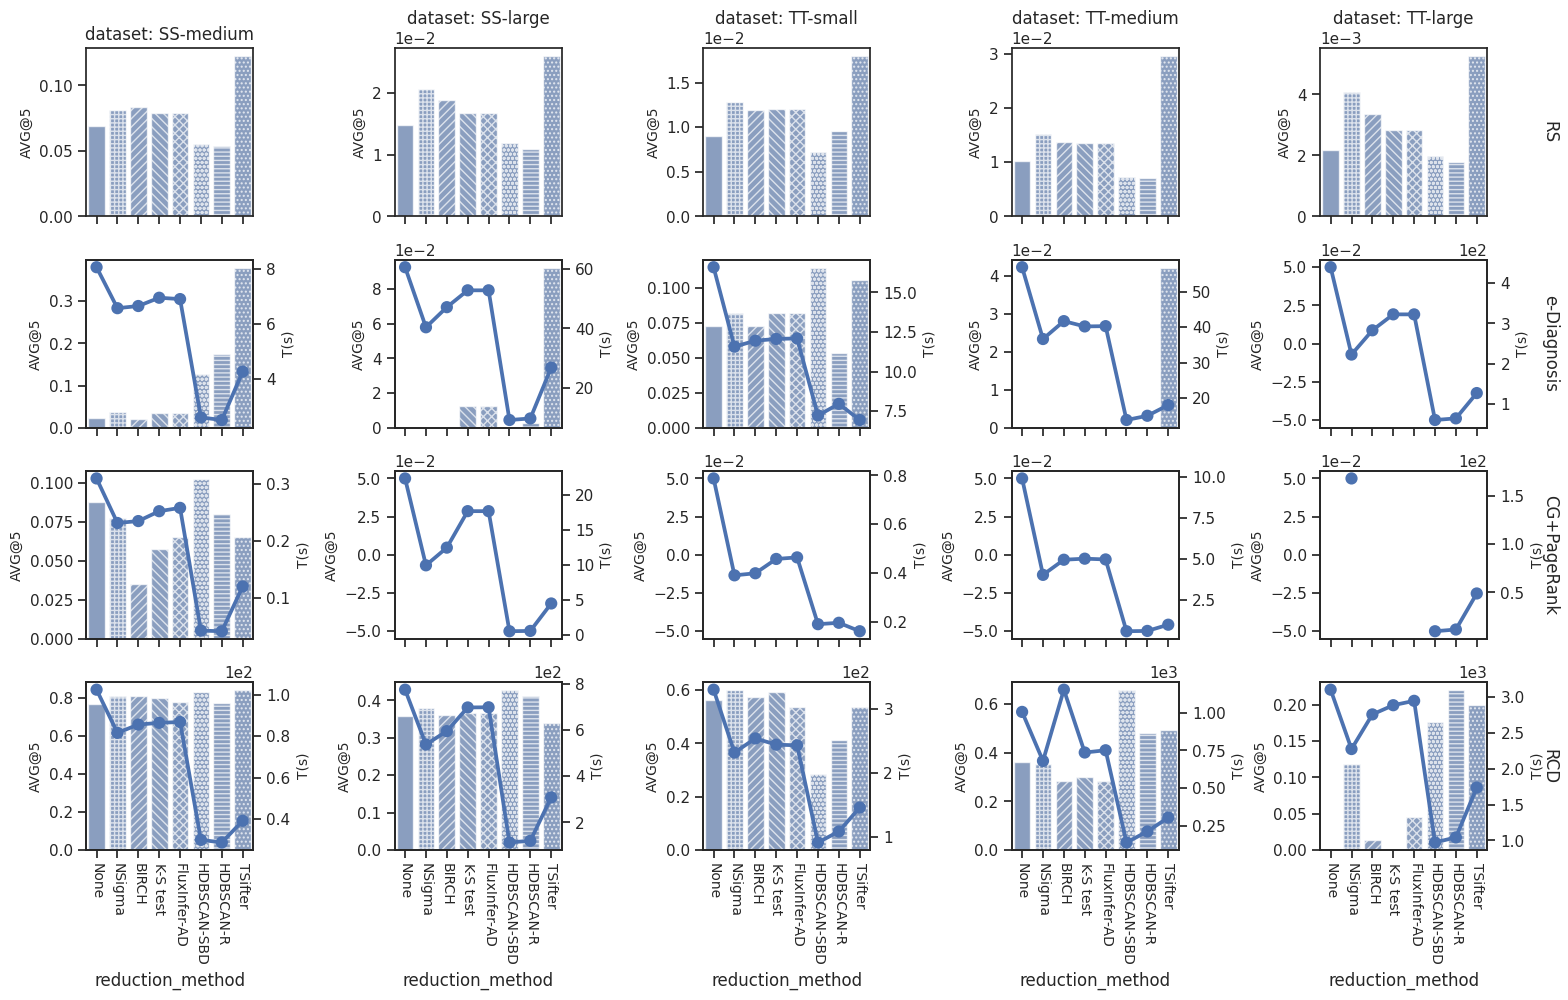

In [485]:
plot_grid(datasets[1:], loc_methods=LOC_METHODS_COMMON, col="dataset", row="localization_method")

/tmp/ipykernel_500429/1832136803.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


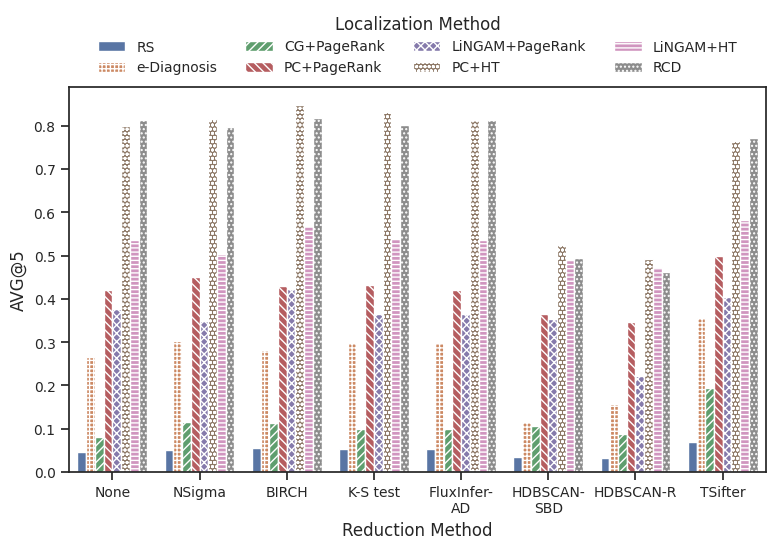

In [466]:
plot_combination("SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)

/tmp/ipykernel_500429/857265757.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


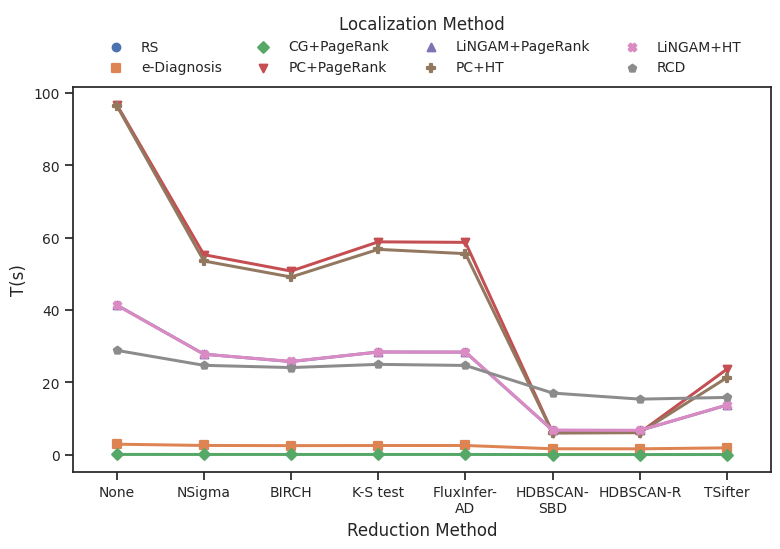

In [473]:
plot_combination("SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS, plot_type="point")

In [53]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)

({'AC_1': 0.021944444444444433,
  'AC_2': 0.04333310185185187,
  'AC_3': 0.06418163560956791,
  'AC_4': 0.08450523611095033,
  'AC_5': 0.10431863564118209},
 {'AVG_1': 0.021944444444444433,
  'AVG_2': 0.032638773148148156,
  'AVG_3': 0.04315306063528807,
  'AVG_4': 0.053491104504203635,
  'AVG_5': 0.06365661073159933})